In [275]:
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
import time 
sns.set()
breast_cancer_data = pd.read_csv('/Users/vishesh.javangula@ibm.com/Downloads/data.csv')

# Dataset Details

The data set is skews more toward bengin classification than maignant. This was taken into consideration when determining the train test split method. The visualization also tells us the we have a relatively small dataset of about roughly 550 samples. All the features are numeric except for diagnosis, which is what we are trying to predict. Before procoding any further it is important we convert this column to values of -1 and 1. Finally, we need highly correlated features that minimize colinearity. We found this by displaying a heatmap of the correlation coefficients between each pair of features. We noted that concave points_mean and texture_worst are the best features to use for this classiication problem. To visualize the feature space with respect to diagnosis, we created a scatter plot with the hue of each point denoting which class it belongs to. In terms of train-test-split, the literature states that SVM performs well under stratified sampling. Therefore we sampled 90% of the data from each classification. The reason we choose 90% is because of the small size of our data set, maximizing the training data size allowed us to better determine generalized decision boundaries. 

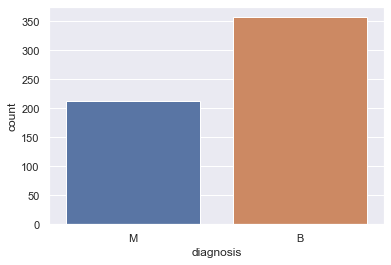

In [277]:
#How big and balanced is my dataset? --> skewed toward bengin and small dataset of 550, therefore will use wholebatch gradient descent
#data is skewed, literature stats SVM performs well in stratified sampling --> https://link.springer.com/chapter/10.1007/11552499_86
ax = sns.countplot(x='diagnosis',data=breast_cancer_data)

In [278]:
#Are all my features numerical or does there need to be any reformatting?
breast_cancer_data.dtypes

id                           int64
diagnosis                   object
radius_mean                float64
texture_mean               float64
perimeter_mean             float64
area_mean                  float64
smoothness_mean            float64
compactness_mean           float64
concavity_mean             float64
concave points_mean        float64
symmetry_mean              float64
fractal_dimension_mean     float64
radius_se                  float64
texture_se                 float64
perimeter_se               float64
area_se                    float64
smoothness_se              float64
compactness_se             float64
concavity_se               float64
concave points_se          float64
symmetry_se                float64
fractal_dimension_se       float64
radius_worst               float64
texture_worst              float64
perimeter_worst            float64
area_worst                 float64
smoothness_worst           float64
compactness_worst          float64
concavity_worst     

In [279]:
for index,val in breast_cancer_data['diagnosis'].items():
    if(val == 'M'):
        breast_cancer_data['diagnosis'].iloc[index] = 1
    if(val == 'B'):
        breast_cancer_data['diagnosis'].iloc[index] = -1

/opt/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [281]:
breast_cancer_data.drop(columns='Unnamed: 32', inplace=True)

<AxesSubplot:>

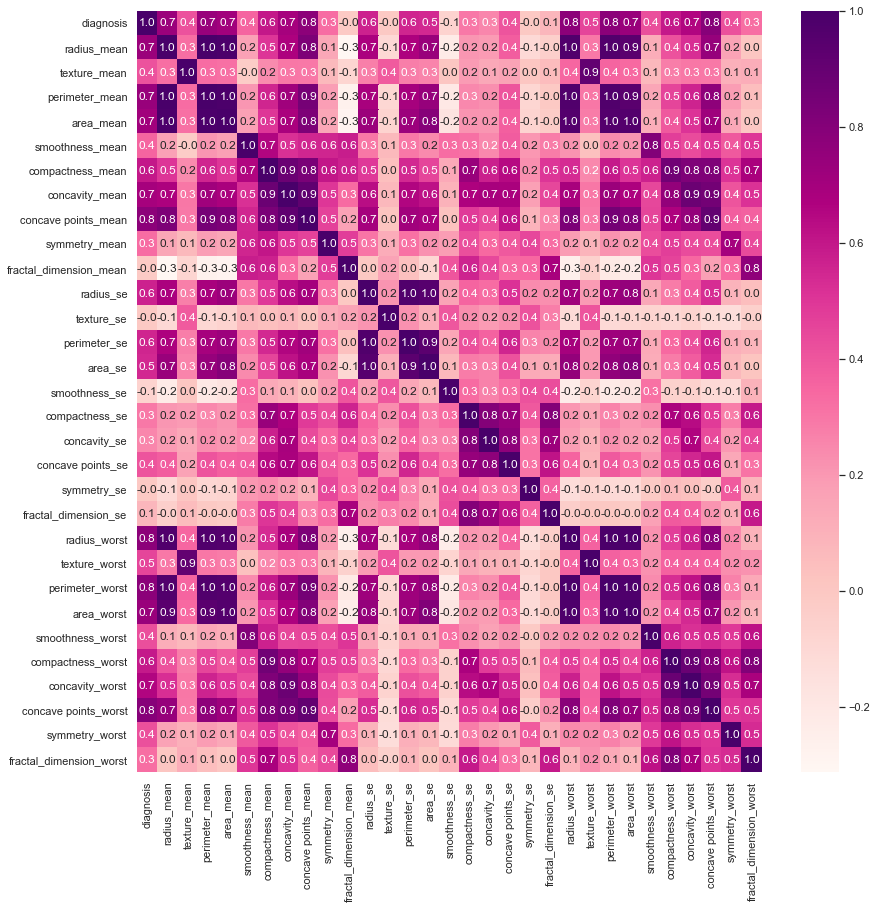

In [284]:
fig = plt.figure(figsize=(14,14))
ax = sns.heatmap(breast_cancer_data[['diagnosis','radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'perimeter_se', 'area_se', 'smoothness_se',
       'compactness_se', 'concavity_se', 'concave points_se', 'symmetry_se',
       'fractal_dimension_se', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave points_worst',
       'symmetry_worst', 'fractal_dimension_worst']].corr(), cmap='RdPu', annot=True, fmt='.1f')
plt.axes(ax)

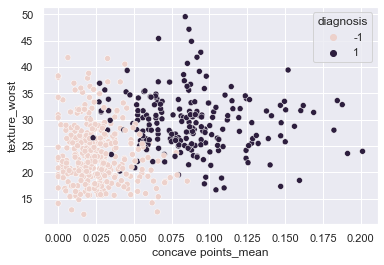

In [198]:
ax = sns.scatterplot(x='concave points_mean', y = 'texture_worst', data = breast_cancer_data, hue = 'diagnosis')


# Algorithm Description

Since we are only concerned with two features, we first reduce the feature space to consist of concave points_mean and texture_worst. SVM benefits from normalization of features but also needs the each feature to range from -x to +x. This allows us to create predictions based on if the model output is greater than or less than 0. Therefore we transformed each feature to range from -3 to 3. SVM also benefits from having a bias term. This allows an additional degree of freedom when placing the desicion boundary in the feature space. An additional feature labeled 'bias' with a value of 1 was added to training and testing data to accomdate for an additional weight. Because the data does not appear to be perfectly linearly seperable, soft SVM was used along with hyperparameter tuning for the C value. Hinge Loss and Batch Gradient descent was used since we had a small dataset. 

In [286]:
breast_cancer_data = breast_cancer_data[['concave points_mean', 'texture_worst', 'diagnosis']]

In [267]:
#train test split
#Because of small dataset, i'll be using cross-fold-validation in the validation/test set will be 4 samples to maximize our training data
def trainTestSplit():
    #data = housing_data.groupby(pd.cut(housing_data['grade'], 13))
    data= breast_cancer_data.groupby(by='diagnosis')
    train = pd.DataFrame()
    for label, group in data:
            train = pd.concat([train,group.sample(n=int(0.90*group.shape[0]))])
    

    #create test set
    test = breast_cancer_data.merge(train, how='left', indicator=True)
    test = test[test['_merge'] == 'left_only']
    
    #reset indicies
    train.reset_index(drop=True, inplace=True)
    test.reset_index(drop=True, inplace=True)

    #create labels
    test_label = test['diagnosis'].to_frame()
    test.drop(columns=['_merge','diagnosis'], inplace=True)
    train_label = train['diagnosis'].to_frame()
    train.drop(columns=['diagnosis'], inplace=True)
    
    #normalize data between [-3,3]
    for column in train:
        train[column] = 6*((train[column]-train[column].min())/(train[column].max() - train[column].min())) -3
        test[column] = 6*((test[column]-test[column].min())/(test[column].max() - test[column].min())) -3
        
    #Add column for bias term
    train['bias'] = 1
    test['bias'] = 1
    

    return (train, train_label, test, test_label)

In [268]:
def isDone(prev, curr):
    diff = prev-curr
    diff = np.absolute(diff)
    result = True
    for i in diff:
        if (i >0.001):
            result = False
    return result

In [269]:
def fit(x_train, y_train, C):
    #random weight vector
    model = np.random.rand(3)
    # given current weight vector calculate gradient, which leverages loss and entire dataset
    while(True): #epochs
        gradient = np.zeros(3)
        loss = 0
        for index, series in x_train.iterrows():
            loss += 0.5*np.dot(model,model) + C * max(0,1-(y_train.iat[index,0]*np.dot(model, series.to_numpy())))
            if(1- (y_train.iat[index,0]*np.dot(model, series.to_numpy())) <=0):
                gradient += model
            else:
                gradient += model - (C * y_train.iat[index,0]*series.to_numpy())
        prev = model
        model = model - .001 * (gradient/x_train.shape[0])
        if(isDone(prev,model)):
            break
        

    return model

In [270]:
#model is a series of weights
def score(model, x_test, y_test,ax):
    result = np.zeros((2,2)) #length of array should be # of rows in x_test
    for index, series in x_test.iterrows():
        if(np.dot(model, series.to_numpy()) < 0 and y_test.iat[index,0] == -1):
            result[0][0] += 1 #resuts
        if(np.dot(model, series.to_numpy()) < 0 and y_test.iat[index,0] == 1):
            result[1][0] += 1 #resuts
        if(np.dot(model, series.to_numpy()) >=0 and y_test.iat[index,0] == 1):
            result[1][1] += 1 #resuts
        if(np.dot(model, series.to_numpy()) >= 0 and y_test.iat[index,0] == -1):
            result[0][1] += 1 #resuts
    return sns.heatmap(data=result, annot=True, fmt="f", ax=ax)
    

# Algorithm Results

With Soft SVM it is not clear what the optimal value of C is. Therefore we used hyperparameter tuning with c values ranging from 0.1, 1, and 10. According to the results C=10 performed the best with accuracy scores of 94% and 91% and precision values of 94% and 91% for B and M respecively.

average time to complete is 80666.66666666667 ms


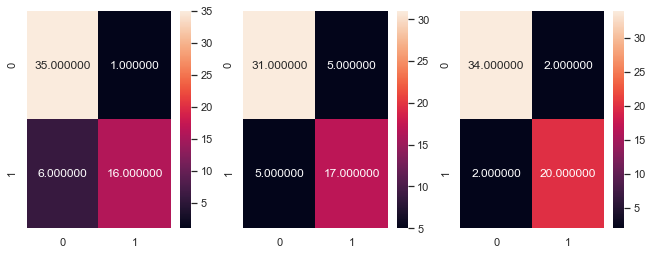

In [288]:
fig,axes = plt.subplots(1,3, figsize=(11,4))
index = 0
t = np.zeros(3)
for c in [0.1,1,10]:
    x_train, y_train, x_test, y_test = trainTestSplit()
    model = fit(x_train,y_train, c)
    prev = int(round(time.time() * 1000))
    score(model, x_test, y_test,axes[index])
    curr = int(round(time.time() * 1000))
    t[index] = (curr-prev) * 1000
    index +=1
print('average time to complete is {} ms'.format(np.average(t)))

# Time Complexity

scoring the test data requires us to apply the weights to each feature, then check if the value is greater than or less than 0. Therefore the number of opertions is dependent on the size of the test set (N). Our runtime is therefore O(N). It took the algorithm 80,000 ms on average to score the test set of size 56. 

# Sources 

https://link.springer.com/chapter/10.1007/11552499_86
https://towardsdatascience.com/solving-svm-stochastic-gradient-descent-and-hinge-loss-8e8b4dd91f5b